In [2]:
%cd ../

/mnt2/kireev/pycharm-deploy/pytorch-lifestream/experiments/scenario_shoppers


In [3]:
!ls -l ./data/

total 6003388
-rw-r--r-- 1 ivan sudo 3074186129 Jan 24 14:40 acquire-valued-shoppers.zip
-rw-rw-r-- 1 ivan sudo        431 Dec 11  2019 offers.csv.gz
-rw-rw-r-- 1 ivan sudo     455218 Dec 11  2019 sampleSubmission.csv.gz
-rw-rw-r-- 1 ivan sudo     930437 Dec 11  2019 testHistory.csv.gz
-rw-rw-r-- 1 ivan sudo    1014650 Dec 11  2019 trainHistory.csv.gz
-rw-rw-r-- 1 ivan sudo 3070857478 Dec 11  2019 transactions.csv.gz


https://www.kaggle.com/c/acquire-valued-shoppers-challenge/data

In [4]:
import numpy as np
import pandas as pd

In [5]:
from IPython.display import display

In [6]:
import matplotlib.pyplot as plt

In [7]:
pd.options.display.max_columns = 50

In [8]:
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql import SparkSession
from pyspark.sql import Window

In [9]:
spark_conf = {
    'spark.driver.memory': '128G',
    'spark.sql.shuffle.partitions': '500',
    'spark.sql.parquet.compression.codec': "snappy",
    'spark.ui.port': '4041',
    'spark.local.dir': "data/.spark_local_dir",
}

In [10]:
spark = SparkSession.builder
for k, v in spark_conf.items():
    spark = spark.config(k, v)
spark = spark.appName('"Shoppers Make Dataset"')
spark = spark.master('local[10]')
spark = spark.getOrCreate()

22/01/25 09:52:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/01/25 09:52:26 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [11]:
df_trx = spark.read.csv('./data/transactions.csv.gz', header=True)

In [12]:
df_trx.limit(10).toPandas()

,id,chain,dept,category,company,brand,date,productsize,productmeasure,purchasequantity,purchaseamount
0,86246,205,7,707,1078778070,12564,2012-03-02,12,OZ,1,7.59
1,86246,205,63,6319,107654575,17876,2012-03-02,64,OZ,1,1.59
2,86246,205,97,9753,1022027929,0,2012-03-02,1,CT,1,5.99
3,86246,205,25,2509,107996777,31373,2012-03-02,16,OZ,1,1.99
4,86246,205,55,5555,107684070,32094,2012-03-02,16,OZ,2,10.38
5,86246,205,97,9753,1021015020,0,2012-03-02,1,CT,1,7.8
6,86246,205,99,9909,104538848,15343,2012-03-02,16,OZ,1,2.49
7,86246,205,59,5907,102900020,2012,2012-03-02,16,OZ,1,1.39
8,86246,205,9,921,101128414,9209,2012-03-02,4,OZ,2,1.5
9,86246,205,73,7344,1068142161,20285,2012-03-02,8,CT,1,5.79


In [13]:
df_trx.persist()
df_trx.count()

349655789

In [14]:
df_trx.where("chain is Null").limit(10).toPandas()

,id,chain,dept,category,company,brand,date,productsize,productmeasure,purchasequantity,purchaseamount


In [15]:
df_train_hist = spark.read.csv('./data/trainHistory.csv.gz', header=True)

In [16]:
df_train_hist.limit(10).toPandas()

,id,chain,offer,market,repeattrips,repeater,offerdate
0,86246,205,1208251,34,5,t,2013-04-24
1,86252,205,1197502,34,16,t,2013-03-27
2,12682470,18,1197502,11,0,f,2013-03-28
3,12996040,15,1197502,9,0,f,2013-03-25
4,13089312,15,1204821,9,0,f,2013-04-01
5,13179265,14,1197502,8,0,f,2013-03-29
6,13251776,15,1200581,9,0,f,2013-03-30
7,13540129,14,1200581,8,0,f,2013-03-30
8,13807224,4,1204576,1,0,f,2013-04-05
9,13873775,4,1197502,1,0,f,2013-03-26


In [17]:
df_train_hist.persist()
df_train_hist.count()

160057

In [18]:
df_test_hist = spark.read.csv('./data/testHistory.csv.gz', header=True)

In [19]:
df_test_hist.limit(10).toPandas()

,id,chain,offer,market,offerdate
0,12262064,95,1219903,39,2013-06-27
1,12277270,95,1221658,39,2013-06-23
2,12332190,95,1213242,39,2013-06-15
3,12524696,4,1221665,1,2013-06-20
4,13074629,14,1221658,8,2013-06-21
5,13387341,14,1221658,8,2013-06-22
6,13501141,4,1203439,1,2013-05-13
7,13558712,15,1203439,9,2013-05-12
8,13563017,14,1221665,8,2013-06-24
9,13584134,14,1221665,8,2013-06-27


In [20]:
df_test_hist.persist()
df_test_hist.count()

151484

In [31]:
160057 + 151484

311541

In [21]:
df_offers = spark.read.csv('./data/offers.csv.gz', header=True)

In [22]:
df_offers.limit(10).toPandas()

,offer,category,quantity,company,offervalue,brand
0,1190530,9115,1,108500080,5,93904
1,1194044,9909,1,107127979,1,6732
2,1197502,3203,1,106414464,0.75,13474
3,1198271,5558,1,107120272,1.5,5072
4,1198272,5558,1,107120272,1.5,5072
5,1198273,5558,1,107120272,1.5,5072
6,1198274,5558,1,107120272,1.5,5072
7,1198275,5558,1,107120272,1.5,5072
8,1199256,4401,1,105100050,2,13791
9,1199258,4401,1,105100050,2,13791


In [23]:
df_offers.persist()
df_offers.count()

37

In [24]:
df_sample = spark.read.csv('./data/sampleSubmission.csv.gz', header=True)

In [25]:
df_sample.limit(10).toPandas()

,id,repeatProbability
0,12262064,0
1,12277270,0
2,12332190,0
3,12524696,0
4,13074629,0
5,13387341,0
6,13501141,0
7,13558712,0
8,13563017,0
9,13584134,0


In [26]:
df_sample.count()

151484

In [27]:
df_trx.limit(5).toPandas()

,id,chain,dept,category,company,brand,date,productsize,productmeasure,purchasequantity,purchaseamount
0,86246,205,7,707,1078778070,12564,2012-03-02,12,OZ,1,7.59
1,86246,205,63,6319,107654575,17876,2012-03-02,64,OZ,1,1.59
2,86246,205,97,9753,1022027929,0,2012-03-02,1,CT,1,5.99
3,86246,205,25,2509,107996777,31373,2012-03-02,16,OZ,1,1.99
4,86246,205,55,5555,107684070,32094,2012-03-02,16,OZ,2,10.38


In [29]:
# unique clients
df_trx.groupby('id').count().count()

311541

In [30]:
# unique clients
df_trx.groupby('chain').count().count()

134

In [32]:
# unique clients
df_trx.groupby('id', 'chain').count().count()

311548

In [33]:
# unique clients
df_trx.groupby('id', 'chain').count() \
.withColumn('cn', F.count('*').over(Window.partitionBy('id'))).where('cn > 1').limit(100).toPandas()

,id,chain,count,cn
0,122112062,88,68,2
1,122112062,15,774,2
2,4632223858,153,224,2
3,4632223858,152,410,2
4,141489865,88,484,2
5,141489865,18,1175,2
6,4427711419,153,110084,2
7,4427711419,152,137472,2
8,446862868,64,103,2
9,446862868,70,275,2


In [35]:
df_test_hist.where('id = 122112062').limit(100).toPandas()

,id,chain,offer,market,offerdate
0,122112062,15,1219900,9,2013-06-29


In [41]:
df_trx.join(
    df_train_hist.select('id', 'chain', 'offerdate'), on=['id', 'chain'], how='inner',
).where("date > offerdate").limit(5).toPandas()

,id,chain,dept,category,company,brand,date,productsize,productmeasure,purchasequantity,purchaseamount,offerdate


In [40]:
df_trx.join(
    df_test_hist.select('id', 'chain', 'offerdate'), on=['id', 'chain'], how='inner',
).where("date > offerdate").limit(5).toPandas()

,id,chain,dept,category,company,brand,date,productsize,productmeasure,purchasequantity,purchaseamount,offerdate


In [49]:
df = df_train_hist.withColumn('repeattrips', F.col('repeattrips').cast('int')) \
.groupby('repeater', 'repeattrips').count().toPandas()

In [50]:
df.sort_values('repeattrips')

,repeater,repeattrips,count
14,f,0,116619
0,t,1,24742
10,t,2,8269
33,t,3,3646
19,t,4,2020
23,t,5,1367
43,t,6,809
49,t,7,588
48,t,8,443
7,t,9,315


In [68]:
df = df_train_hist.withColumn('repeattrips', F.col('repeattrips').cast('int')) \
.withColumn('kind', F.lit('train')).union(
    df_test_hist.withColumn('repeattrips', F.lit(-1)).withColumn('repeater', F.lit('u'))
    .select(*df_train_hist.columns).withColumn('kind', F.lit('test')),
)

In [69]:
df

DataFrame[id: string, chain: string, offer: string, market: string, repeattrips: int, repeater: string, offerdate: string, kind: string]

In [70]:
df.groupby('offer').count().toPandas().sort_values('count', ascending=False)

,offer,count
21,1197502,45652
9,1221663,43819
19,1221658,32447
16,1230218,23350
18,1208329,19117
30,1208251,15529
24,1203052,15337
0,1203439,12864
15,1199256,7971
27,1204576,7832


In [71]:
df.groupby('market').count().toPandas().sort_values('count', ascending=False)

,market,count
30,10,50787
16,96,26244
17,21,18455
13,15,16313
20,8,15225
5,93,14994
15,20,14330
3,27,13318
9,9,12401
22,37,11342


In [72]:
df.groupby('offerdate').count().toPandas().sort_values('count', ascending=False)

,offerdate,count
84,2013-06-20,15575
85,2013-06-22,14048
139,2013-06-21,13299
99,2013-06-23,11497
133,2013-03-25,10922
...,...,...
17,2013-07-30,9
63,2013-06-16,4
18,2013-06-12,3
110,2013-06-13,1


In [73]:
df.groupby('offerdate', 'kind').count().toPandas().sort_values('offerdate')

,offerdate,kind,count
86,2013-03-01,train,1179
34,2013-03-02,train,1000
8,2013-03-03,train,745
79,2013-03-04,train,597
3,2013-03-05,train,496
...,...,...,...
124,2013-07-27,test,3867
4,2013-07-28,test,2926
106,2013-07-29,test,1899
108,2013-07-30,test,9


In [75]:
ws = Window.partitionBy('repeater', 'repeattrips', 'offer', 'market', 'chain')
df = df_train_hist \
.withColumn('repeattrips', 
            F.when(F.col('repeattrips') <= 4, F.col('repeattrips')).otherwise(F.lit(5))) \
.withColumn('_hash', F.hash(
    F.concat(F.col('id'), F.lit('self.config.salt'))) / 2**32 + 0.5)
df = df.withColumn('p', F.row_number().over(ws.orderBy('_hash')) / F.count('*').over(ws))

df_target_train = df.where(F.col('p') >= 0.1).drop('_hash', 'p')
df_target_test = df.where(F.col('p') < 0.1).drop('_hash', 'p')
df_target_train.persist()
df_target_test.persist()


DataFrame[id: string, chain: string, offer: string, market: string, repeattrips: string, repeater: string, offerdate: string]

In [77]:
df_target_test.count()

14643

In [78]:
df_trx

DataFrame[id: string, chain: string, dept: string, category: string, company: string, brand: string, date: string, productsize: string, productmeasure: string, purchasequantity: string, purchaseamount: string]

In [79]:
df_trx_train = df_trx.join(
    df_target_test.select('id'),
    on='id',
    how='left_anti',
).join(
    df_target_train,
    on=['id', 'chain'],
    how='left',
)
df_trx_test = df_trx.join(
    df_target_test,
    on=['id', 'chain'],
    how='inner',
)


In [80]:
df_trx_train.count()

334498700

In [81]:
df_trx_test.count()

15157089

In [82]:
df_trx_train.groupby('id').count().count()

296898

In [83]:
df_trx_test.groupby('id').count().count()

14643

In [85]:
df_trx_train.limit(5).toPandas()

,id,chain,dept,category,company,brand,date,productsize,productmeasure,purchasequantity,purchaseamount,offer,market,repeattrips,repeater,offerdate
0,86246,205,7,707,1078778070,12564,2012-03-02,12,OZ,1,7.59,1208251,34,5,t,2013-04-24
1,86246,205,63,6319,107654575,17876,2012-03-02,64,OZ,1,1.59,1208251,34,5,t,2013-04-24
2,86246,205,97,9753,1022027929,0,2012-03-02,1,CT,1,5.99,1208251,34,5,t,2013-04-24
3,86246,205,25,2509,107996777,31373,2012-03-02,16,OZ,1,1.99,1208251,34,5,t,2013-04-24
4,86246,205,55,5555,107684070,32094,2012-03-02,16,OZ,2,10.38,1208251,34,5,t,2013-04-24


In [93]:
df_trx_train.groupby('productmeasure').count().toPandas().sort_values('count', ascending=False)

,productmeasure,count
8,OZ,272576923
9,CT,40250584
0,None,11002057
3,RL,4182259
4,LB,3762795
11,LT,2597695
10,YD,123886
6,1,1617
1,FT,492
5,QT,209


In [113]:
df_trx_train.groupby('productsize', 'productmeasure').count() \
.toPandas().sort_values('count', ascending=False).iloc[:100]

,productsize,productmeasure,count
3222,16,OZ,29528165
2588,1,CT,17175582
2349,12,OZ,15912919
1864,8,OZ,13847809
2925,0,None,11002057
...,...,...,...
157,16.9,OZ,460136
2100,2.5,OZ,458790
1341,14.1,OZ,446557
1796,6,CT,444632


In [99]:
df_trx.withColumn('f', F.col('purchaseamount').cast('float')).limit(10).toPandas()

,id,chain,dept,category,company,brand,date,productsize,productmeasure,purchasequantity,purchaseamount,f
0,86246,205,7,707,1078778070,12564,2012-03-02,12,OZ,1,7.59,7.59
1,86246,205,63,6319,107654575,17876,2012-03-02,64,OZ,1,1.59,1.59
2,86246,205,97,9753,1022027929,0,2012-03-02,1,CT,1,5.99,5.99
3,86246,205,25,2509,107996777,31373,2012-03-02,16,OZ,1,1.99,1.99
4,86246,205,55,5555,107684070,32094,2012-03-02,16,OZ,2,10.38,10.38
5,86246,205,97,9753,1021015020,0,2012-03-02,1,CT,1,7.8,7.80
6,86246,205,99,9909,104538848,15343,2012-03-02,16,OZ,1,2.49,2.49
7,86246,205,59,5907,102900020,2012,2012-03-02,16,OZ,1,1.39,1.39
8,86246,205,9,921,101128414,9209,2012-03-02,4,OZ,2,1.5,1.50
9,86246,205,73,7344,1068142161,20285,2012-03-02,8,CT,1,5.79,5.79


In [92]:
for col in ['dept', 'category', 'company', 'brand']:
    display(df_trx_train.groupby(col).count().toPandas().sort_values('count', ascending=False))
    display(df_trx.groupby(col).count().groupby().agg(
        F.min(col).alias(f'{col}_min'),
        F.max(col).alias(f'{col}_max'),
        F.count(col).alias(f'{col}_cnt'),
    ).toPandas())

,dept,count
21,9,29671587
26,63,21965881
23,36,15900267
36,99,14502112
16,33,13914859
...,...,...
71,47,289980
80,50,247679
43,78,157418
35,98,42154


,dept_min,dept_max,dept_cnt
0,0,99,83


,category,count
752,907,10302982
402,6315,8003612
26,9753,6933194
795,501,6468314
510,9908,6024139
...,...,...
283,1899,7
234,7499,3
681,6099,2
543,3799,1


,category_min,category_max,category_cnt
0,0,9999,836


,company,count
2687,101111010,20174824
8916,10000,7638087
8785,1068826767,7476177
1732,104119040,6054228
21022,102840020,5807308
...,...,...
19748,1072848979,1
3722,1085515282,1
11966,1073375373,1
19758,10487949,1


,company_min,company_max,company_cnt
0,10000,10999999999,32773


,brand,count
30551,9907,16435185
30984,0,11826336
28095,16347,5972829
33963,88199,5154194
19316,33170,5088929
...,...,...
22932,42242,1
5242,5942,1
11425,62625,1
5241,71465,1


,brand_min,brand_max,brand_cnt
0,0,99995,35689


In [116]:
df_trx_train.groupby('category').count().toPandas().sort_values('count', ascending=False).iloc[:700]

,category,count
752,907,10302982
402,6315,8003612
26,9753,6933194
795,501,6468314
510,9908,6024139
...,...,...
18,3107,18265
649,2502,18117
559,209,17737
737,9747,17715


In [107]:
df_train_hist \
.withColumn('repeater', F.when(F.col('repeater') == 'f', F.lit(0)).otherwise(F.lit(1))) \
.groupby('offer').agg(F.avg('repeater').alias('mean_rate')).toPandas() \
.sort_values('mean_rate', ascending=False)

,offer,mean_rate
21,1194044,0.507048
10,1208329,0.434379
14,1203052,0.423616
13,1208501,0.377841
15,1208503,0.341069
18,1208251,0.320934
19,1208252,0.304745
16,1204576,0.284519
4,1200584,0.229730
23,1198272,0.214137


In [106]:
df_train_hist \
.withColumn('repeater', F.when(F.col('repeater') == 'f', F.lit(0)).otherwise(F.lit(1))) \
.groupby('market').agg(F.avg('repeater').alias('mean_rate')).toPandas() \
.sort_values('mean_rate', ascending=False)

,market,mean_rate
23,14,0.446893
17,21,0.363847
25,34,0.314710
9,9,0.290664
7,35,0.288839
30,10,0.286382
3,27,0.283239
31,4,0.281016
15,20,0.273729
20,8,0.271699


In [109]:
df_train_hist \
.withColumn('repeater', F.when(F.col('repeater') == 'f', F.lit(0)).otherwise(F.lit(1))) \
.groupby('offer', 'market').agg(F.count('repeater').alias('mean_rate')).toPandas() \
.pivot(index='market', columns='offer')

mean_rate                                                          \
offer    1194044 1197502 1198271 1198272 1198273 1198274 1198275 1199256   
market                                                                     
1            NaN  2718.0    66.0   105.0    72.0    36.0    52.0    98.0   
10           NaN  6416.0   191.0   630.0   254.0   293.0   840.0  4677.0   
11           NaN  1058.0    10.0    20.0    11.0    13.0     7.0    37.0   
12           NaN  1907.0    43.0    81.0    33.0    48.0   111.0   392.0   
14           NaN   874.0     NaN     NaN     NaN     NaN     NaN     NaN   
15           NaN  2616.0    47.0   152.0    63.0    93.0    40.0   435.0   
16           NaN  1774.0     3.0     5.0     2.0    17.0    19.0     5.0   
17           NaN   535.0     NaN     NaN     NaN     NaN     NaN   138.0   
18           NaN   758.0     NaN     NaN     NaN     NaN     NaN    10.0   
2            NaN   900.0    38.0    69.0    50.0    22.0    57.0   111.0   
20           NaN  2661.0    60.0   130.0    39.0    44.0   140.0   131.0   
21        5091.0  2200.0     NaN     NaN     NaN     NaN     NaN   195.0   
22         121.0   619.0     NaN     NaN     NaN     NaN     NaN    44.0   
23           NaN   275.0     NaN     NaN     NaN     NaN     NaN    47.0   
24           NaN   557.0     NaN     NaN     NaN     NaN     NaN     NaN   
26           NaN   468.0     NaN     NaN     NaN     NaN     NaN    58.0   
27           NaN  2136.0   282.0   296.0   159.0   189.0   245.0   313.0   
28           NaN   718.0     9.0    22.0     5.0    12.0     5.0     NaN   
33           NaN  1407.0    53.0    93.0    72.0   100.0   139.0    12.0   
34        1001.0  1474.0     4.0     5.0     NaN    10.0    13.0    58.0   
35         517.0   908.0     NaN     NaN     NaN     NaN     NaN     3.0   
37           NaN  1746.0    84.0   206.0   129.0   183.0   285.0   599.0   
39           NaN  1195.0     NaN     NaN     NaN     NaN     NaN     NaN   
4           80.0  1836.0     4.0     2.0     2.0     NaN     1.0    55.0   
43           NaN   315.0     NaN     NaN     NaN     NaN     NaN     NaN   
45           NaN   412.0     NaN     NaN     NaN     NaN     NaN     NaN   
47           NaN     NaN     1.0     4.0     8.0     3.0     1.0     NaN   
5            NaN    21.0     1.0     3.0     1.0     1.0     2.0     8.0   
6            NaN   380.0     1.0     1.0     NaN     NaN     3.0     2.0   
7            NaN  1105.0     NaN     NaN     NaN     NaN     NaN     NaN   
8            NaN  2569.0    40.0    75.0    60.0    41.0    12.0     NaN   
9            NaN  1693.0    20.0    25.0    32.0    19.0     5.0     NaN   
93           NaN    16.0     NaN     NaN     NaN     NaN     NaN     NaN   
96           NaN  1385.0     NaN     NaN     NaN     NaN     NaN   543.0   

                                                                        \
offer  1199258 1200578 1200579 1200581 1200582 1200584 1200988 1203052   
market                                                                   
1        131.0    72.0    45.0   121.0    46.0     6.0    80.0     NaN   
10      2793.0   641.0   188.0     1.0     NaN     NaN    60.0  7330.0   
11        52.0     NaN     1.0    49.0    19.0     NaN    18.0     NaN   
12       209.0   136.0    26.0    28.0     2.0     2.0    22.0     NaN   
14         NaN    34.0    21.0   178.0    38.0     1.0    39.0  3319.0   
15       865.0   141.0    44.0   538.0    83.0     NaN    62.0     NaN   
16        16.0   133.0    33.0   545.0    57.0     NaN    81.0     NaN   
17       152.0     NaN     NaN    12.0     2.0     NaN    35.0     NaN   
18        22.0    82.0    18.0   184.0    29.0     NaN    62.0     NaN   
2        144.0     1.0     NaN    40.0     8.0     NaN     3.0     NaN   
20       146.0   241.0    62.0     NaN     NaN     5.0    55.0     NaN   
21       613.0    80.0    41.0     NaN     NaN     6.0    95.0     NaN   
22       245.0     8.0     7.0     NaN     NaN     NaN    34.0     NaN   
23        

In [108]:
df_train_hist \
.withColumn('repeater', F.when(F.col('repeater') == 'f', F.lit(0)).otherwise(F.lit(1))) \
.groupby('offer', 'market').agg(F.avg('repeater').alias('mean_rate')).toPandas() \
.pivot(index='market', columns='offer')

mean_rate                                                              \
offer    1194044   1197502   1198271   1198272   1198273   1198274   1198275   
market                                                                         
1            NaN  0.169242  0.106061  0.190476  0.180556  0.027778  0.192308   
10           NaN  0.226309  0.136126  0.223810  0.232283  0.167235  0.194048   
11           NaN  0.168242  0.000000  0.000000  0.000000  0.153846  0.000000   
12           NaN  0.183010  0.186047  0.234568  0.121212  0.145833  0.117117   
14           NaN  0.205950       NaN       NaN       NaN       NaN       NaN   
15           NaN  0.194190  0.212766  0.177632  0.158730  0.161290  0.150000   
16           NaN  0.228861  0.000000  0.000000  0.000000  0.117647  0.105263   
17           NaN  0.134579       NaN       NaN       NaN       NaN       NaN   
18           NaN  0.222955       NaN       NaN       NaN       NaN       NaN   
2            NaN  0.095556  0.236842  0.217391  0.160000  0.181818  0.192982   
20           NaN  0.213454  0.233333  0.200000  0.256410  0.181818  0.257143   
21      0.512473  0.200000       NaN       NaN       NaN       NaN       NaN   
22      0.388430  0.172859       NaN       NaN       NaN       NaN       NaN   
23           NaN  0.149091       NaN       NaN       NaN       NaN       NaN   
24           NaN  0.215440       NaN       NaN       NaN       NaN       NaN   
26           NaN  0.162393       NaN       NaN       NaN       NaN       NaN   
27           NaN  0.193352  0.262411  0.222973  0.207547  0.211640  0.240816   
28           NaN  0.221448  0.333333  0.181818  0.200000  0.250000  0.000000   
33           NaN  0.101635  0.226415  0.193548  0.166667  0.130000  0.122302   
34      0.526474  0.221167  0.000000  0.400000       NaN  0.000000  0.461538   
35      0.441006  0.210352       NaN       NaN       NaN       NaN       NaN   
37           NaN  0.198740  0.226190  0.242718  0.193798  0.174863  0.235088   
39           NaN  0.200000       NaN       NaN       NaN       NaN       NaN   
4       0.525000  0.202614  0.500000  0.000000  0.000000       NaN  0.000000   
43           NaN  0.222222       NaN       NaN       NaN       NaN       NaN   
45           NaN  0.201456       NaN       NaN       NaN       NaN       NaN   
47           NaN       NaN  0.000000  0.250000  0.250000  0.000000  0.000000   
5            NaN  0.238095  0.000000  0.000000  0.000000  0.000000  0.000000   
6            NaN  0.121053  1.000000  0.000000       NaN       NaN  0.000000   
7            NaN  0.220814       NaN       NaN       NaN       NaN       NaN   
8            NaN  0.212145  0.275000  0.293333  0.150000  0.170732  0.250000   
9            NaN  0.173066  0.250000  0.040000  0.187500  0.210526  0.000000   
93           NaN  0.062500       NaN       NaN       NaN       NaN       NaN   
96           NaN  0.181227       NaN       NaN       NaN       NaN       NaN   

                                                                              \
offer    1199256   1199258   1200578   1200579   1200581   1200582   1200584   
market                                                                         
1       0.071429  0.061069  0.041667  0.044444  0.107438  0.086957  0.166667   
10      0.084670  0.105263  0.054602  0.021277  0.000000       NaN       NaN   
11      0.081081  0.096154       NaN  0.000000  0.142857  0.263158       NaN   
12      0.043367  0.052632  0.073529  0.076923  0.107143  0.000000  0.000000   
14           NaN       NaN  0.058824  0.095238  0.134831  0.105263  0.000000   
15      0.087356  0.136416  0.035461  0.068182  0.092937  0.084337       NaN   
16      0.000000  0.187500  0.067669  0.000000  0.102752  0.122807       NaN   
17      0.065217  0.059211       NaN       NaN  0.000000  0.500000       NaN   
18      0.100000  0.136364  0.060976  0.055556  0.076087  0.068966       NaN   
2       0.036036  0.076389  0.000000       NaN  0.125000  0.000000       NaN   
20    

In [103]:
df_train_hist \
.withColumn('repeater', F.when(F.col('repeater') == 'f', F.lit(0)).otherwise(F.lit(1))) \
.groupby('offer', 'market').agg(F.avg('repeater').alias('mean_rate')).toPandas() \
.pivot(index='market', columns='offer')

mean_rate                                                              \
offer    1194044   1197502   1198271   1198272   1198273   1198274   1198275   
market                                                                         
1            NaN  0.169242  0.106061  0.190476  0.180556  0.027778  0.192308   
10           NaN  0.226309  0.136126  0.223810  0.232283  0.167235  0.194048   
11           NaN  0.168242  0.000000  0.000000  0.000000  0.153846  0.000000   
12           NaN  0.183010  0.186047  0.234568  0.121212  0.145833  0.117117   
14           NaN  0.205950       NaN       NaN       NaN       NaN       NaN   
15           NaN  0.194190  0.212766  0.177632  0.158730  0.161290  0.150000   
16           NaN  0.228861  0.000000  0.000000  0.000000  0.117647  0.105263   
17           NaN  0.134579       NaN       NaN       NaN       NaN       NaN   
18           NaN  0.222955       NaN       NaN       NaN       NaN       NaN   
2            NaN  0.095556  0.236842  0.217391  0.160000  0.181818  0.192982   
20           NaN  0.213454  0.233333  0.200000  0.256410  0.181818  0.257143   
21      0.512473  0.200000       NaN       NaN       NaN       NaN       NaN   
22      0.388430  0.172859       NaN       NaN       NaN       NaN       NaN   
23           NaN  0.149091       NaN       NaN       NaN       NaN       NaN   
24           NaN  0.215440       NaN       NaN       NaN       NaN       NaN   
26           NaN  0.162393       NaN       NaN       NaN       NaN       NaN   
27           NaN  0.193352  0.262411  0.222973  0.207547  0.211640  0.240816   
28           NaN  0.221448  0.333333  0.181818  0.200000  0.250000  0.000000   
33           NaN  0.101635  0.226415  0.193548  0.166667  0.130000  0.122302   
34      0.526474  0.221167  0.000000  0.400000       NaN  0.000000  0.461538   
35      0.441006  0.210352       NaN       NaN       NaN       NaN       NaN   
37           NaN  0.198740  0.226190  0.242718  0.193798  0.174863  0.235088   
39           NaN  0.200000       NaN       NaN       NaN       NaN       NaN   
4       0.525000  0.202614  0.500000  0.000000  0.000000       NaN  0.000000   
43           NaN  0.222222       NaN       NaN       NaN       NaN       NaN   
45           NaN  0.201456       NaN       NaN       NaN       NaN       NaN   
47           NaN       NaN  0.000000  0.250000  0.250000  0.000000  0.000000   
5            NaN  0.238095  0.000000  0.000000  0.000000  0.000000  0.000000   
6            NaN  0.121053  1.000000  0.000000       NaN       NaN  0.000000   
7            NaN  0.220814       NaN       NaN       NaN       NaN       NaN   
8            NaN  0.212145  0.275000  0.293333  0.150000  0.170732  0.250000   
9            NaN  0.173066  0.250000  0.040000  0.187500  0.210526  0.000000   
93           NaN  0.062500       NaN       NaN       NaN       NaN       NaN   
96           NaN  0.181227       NaN       NaN       NaN       NaN       NaN   

                                                                              \
offer    1199256   1199258   1200578   1200579   1200581   1200582   1200584   
market                                                                         
1       0.071429  0.061069  0.041667  0.044444  0.107438  0.086957  0.166667   
10      0.084670  0.105263  0.054602  0.021277  0.000000       NaN       NaN   
11      0.081081  0.096154       NaN  0.000000  0.142857  0.263158       NaN   
12      0.043367  0.052632  0.073529  0.076923  0.107143  0.000000  0.000000   
14           NaN       NaN  0.058824  0.095238  0.134831  0.105263  0.000000   
15      0.087356  0.136416  0.035461  0.068182  0.092937  0.084337       NaN   
16      0.000000  0.187500  0.067669  0.000000  0.102752  0.122807       NaN   
17      0.065217  0.059211       NaN       NaN  0.000000  0.500000       NaN   
18      0.100000  0.136364  0.060976  0.055556  0.076087  0.068966       NaN   
2       0.036036  0.076389  0.000000       NaN  0.125000  0.000000       NaN   
20    

,0,10,20,30,40,50,60,70,80,90,100
col_name,,,,,,,,,,,
purchasequantity,-32255.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,54800.0


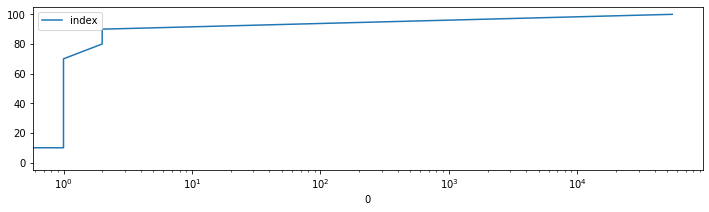

,0,10,20,30,40,50,60,70,80,90,100
col_name,,,,,,,,,,,
purchaseamount,-8593791.0,1.1,1.81,2.29,2.78,3.18,3.79,4.49,5.89,8.07,58658.76


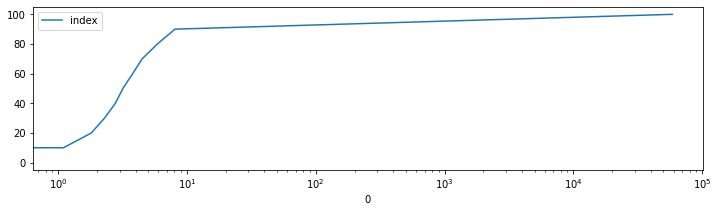

In [110]:
for col in ['purchasequantity', 'purchaseamount']:
    df = df_trx.select(col)
    df = df.groupby().agg(*[F.percentile_approx(col, pos).alias(f'{pos * 100:.0f}')
                            for pos in np.linspace(0, 1, 11)])
    df = df.toPandas()
    display(df.assign(col_name=col).set_index('col_name'))
    
    _, ax = plt.subplots(1, 1, figsize=(12, 3))
    df.T.reset_index().set_index(0).astype(float).plot(ax=ax)
    plt.xscale('log')
    plt.show()


,0,10,20,30,40,50,60,70,80,90,100
col_name,,,,,,,,,,,
count,1,207,371,536,702,877,1069,1296,1584,2029,2647164


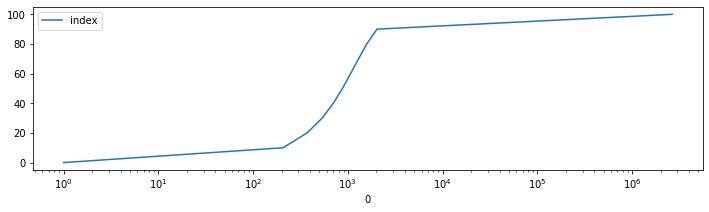

In [117]:
df = df_trx.groupby('id').count()
col = 'count'
df = df.groupby().agg(*[F.percentile_approx(col, pos).alias(f'{pos * 100:.0f}')
                        for pos in np.linspace(0, 1, 11)])
df = df.toPandas()
display(df.assign(col_name=col).set_index('col_name'))

_, ax = plt.subplots(1, 1, figsize=(12, 3))
df.T.reset_index().set_index(0).astype(float).plot(ax=ax)
plt.xscale('log')
plt.show()
